## Part I: The Overreaction Hypothesis 

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



In [20]:

# =====================================================================
# ===================== 第 1 节：读取 & 清洗数据 ======================
# =====================================================================

data_path = '../data/monthly/monthly.csv'
monthly_raw_data = pd.read_csv(data_path)

# 将 RETX、ewretd 转为数值型
monthly_raw_data['RETX'] = pd.to_numeric(monthly_raw_data['RETX'], errors='coerce')
monthly_raw_data['ewretd'] = pd.to_numeric(monthly_raw_data['ewretd'], errors='coerce')

# 用 (RETX - ewretd) 得到“超额收益”
monthly_raw_data['RETX'] = monthly_raw_data['RETX'] - monthly_raw_data['ewretd']

# 去除 NaN 以及RETX为C或者B的行
cleaned_data = monthly_raw_data.dropna(subset=['RETX'])
shape_before = monthly_raw_data.shape
cleaned_data = cleaned_data[~cleaned_data['RETX'].isin(['B','C'])]
shape_after = cleaned_data.shape
print(f"RETX为B或C的行有 {shape_before[0] - shape_after[0]} 行，已经被删除。")

# 转换日期
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# 保证每支股票 >= 85 个月的数据
stocks_with_enough_data = cleaned_data.groupby('PERMNO').filter(lambda x: len(x) >= 85)

# 按 (PERMNO, date) 排序
stocks_with_enough_data = stocks_with_enough_data.sort_values(['PERMNO','date']).reset_index(drop=True)
print(f"符合条件的股票数量: {stocks_with_enough_data['PERMNO'].nunique()}")


RETX为B或C的行有 58583 行，已经被删除。
符合条件的股票数量: 5191


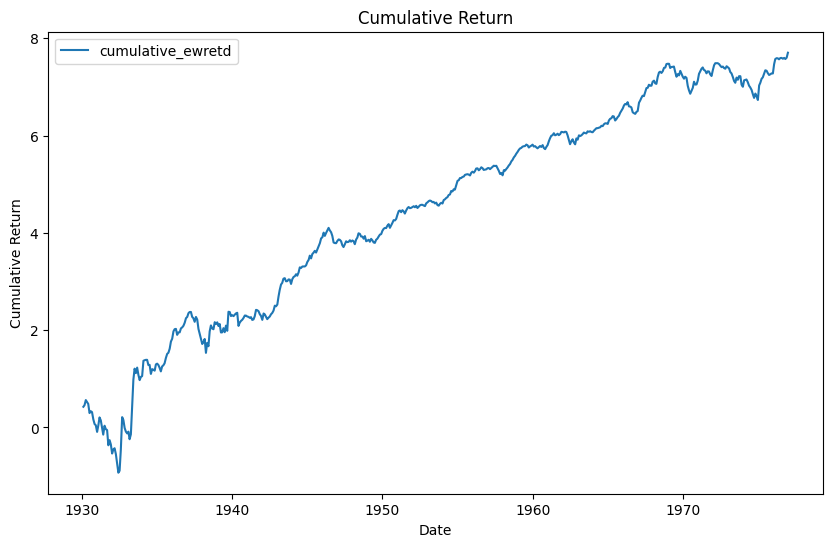

In [21]:
# 计算累计收益

#先按时间聚合求平均
market_data = cleaned_data.groupby('date')['ewretd'].mean().reset_index()
#计算累计收益,累加计算不用累乘
market_data['cumulative_ewretd'] = market_data['ewretd'].cumsum()

#选去1930-1976年的数据
market_data = market_data[(market_data['date'] >= '1930-01-01') & (market_data['date'] <= '1976-12-31')]

#画图
plt.figure(figsize=(10, 6))
plt.plot(market_data['date'], market_data['cumulative_ewretd'], label='cumulative_ewretd')
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


[调仓日期: 1929-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1932-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1935-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1938-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1941-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1944-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1947-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1950-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1953-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1956-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1959-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1962-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1965-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1968-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1971-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1974-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35
====== ACAR (平均累计收益) ======
     t    ACAR_w    ACAR_l      diff
0    1 -0.024585  0.122604  0.147189
1    2 -0.009919  

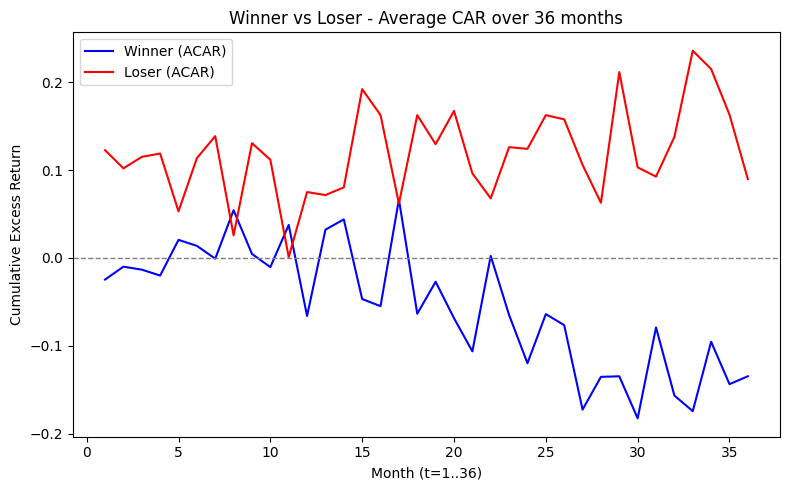

In [22]:


# =====================================================================
# = 第 2 节：计算过去36个月的滚动“复利”累积超额收益 (cum_excess_return) =
# =====================================================================

def calculate_cumulative_excess_returns(group):
    """
    对每只股票按日期顺序,按原文应为加和而非乘积
    """
    # group 已按日期排序
    group['cum_excess_return'] = group['RETX'].rolling(window=36, min_periods=36).sum()
    return group

stocks_with_enough_data = (
    stocks_with_enough_data
    .groupby('PERMNO', group_keys=False)
    .apply(calculate_cumulative_excess_returns)
)


# =====================================================================
# === 第 3 节：人工指定 16 个三年期起点 (1930/01 ~ 1975/01，每三年一次) ===
# =====================================================================

portfolio_starts = [
    pd.Timestamp('1930-01-01'),
    pd.Timestamp('1933-01-01'),
    pd.Timestamp('1936-01-01'),
    pd.Timestamp('1939-01-01'),
    pd.Timestamp('1942-01-01'),
    pd.Timestamp('1945-01-01'),
    pd.Timestamp('1948-01-01'),
    pd.Timestamp('1951-01-01'),
    pd.Timestamp('1954-01-01'),
    pd.Timestamp('1957-01-01'),
    pd.Timestamp('1960-01-01'),
    pd.Timestamp('1963-01-01'),
    pd.Timestamp('1966-01-01'),
    pd.Timestamp('1969-01-01'),
    pd.Timestamp('1972-01-01'),
    pd.Timestamp('1975-01-01'),
]


# =====================================================================
# = 第 4 节：对每个三年期进行回测：组合形成 + 测试期内逐月收益 =
# =====================================================================

all_periods = []  # 用于保存每个测试期(n=1..16)的逐月数据

for start_dt in portfolio_starts:
    # 4.1 组合形成日 = 起点前1个月末
    formation_date = start_dt - pd.offsets.MonthEnd(1)
    
    # lookback: 过去36个月区间 [formation_date-35M, formation_date]
    lookback_end = formation_date
    lookback_start = formation_date - pd.DateOffset(months=35)

    # 提取 lookback 区间的数据
    lookback_df = stocks_with_enough_data[
        (stocks_with_enough_data['date'] >= lookback_start) &
        (stocks_with_enough_data['date'] <= lookback_end)
    ].copy()
    if lookback_df.empty:
        # 没数据就跳过
        continue
    
    # 对每只股票取 <= formation_date 最新一条记录
    sub = lookback_df[lookback_df['date'] <= formation_date]
    # 每只股票只保留最后一条(含 cum_excess_return)
    portfolio_data = sub.groupby('PERMNO', group_keys=False).tail(1).copy()
    
    # 排序，选最高35(赢家), 最低35(输家)
    portfolio_data = portfolio_data.sort_values('cum_excess_return', ascending=False)
    # 先删除cum_excess_return缺失的行
    portfolio_data = portfolio_data.dropna(subset=['cum_excess_return'])
    winner_ids = portfolio_data.head(35)['PERMNO']
    loser_ids  = portfolio_data.tail(35)['PERMNO']
    
    # -------------- 日志功能：打印调仓信息 -------------
    print("\n[调仓日期: {}]".format(formation_date.date()))
    print("  Winner组合股票数:", len(winner_ids))
    print("  Loser组合股票数:", len(loser_ids))
    # 如果还想查看具体股票ID，可直接打印 winner_ids.values 等
    # print("  Winner IDs:", winner_ids.values)
    # print("  Loser IDs:", loser_ids.values)
    # -----------------------------------------------
    
    # 4.2 三年持有期 = [start_dt, start_dt+36个月 - 1天]
    hold_start = start_dt
    hold_end   = start_dt + pd.DateOffset(months=36) - pd.Timedelta(days=1)
    
    # 赢家/输家组合 在持有期内的数据
    w_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(winner_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    l_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(loser_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    
    # 若两组都无数据，也要存个空表做记录
    if w_hold.empty or l_hold.empty:
        all_periods.append(pd.DataFrame({
            'test_period_start': [start_dt],
            'date': [None],
            'avg_u_w': [np.nan],
            'avg_u_l': [np.nan],
        }))
        continue

    # 4.3 每月组合收益
    # 赢家组合：按月份聚合求均值
    w_monthly = w_hold.groupby('date', as_index=False)['RETX'].mean()
    w_monthly.rename(columns={'RETX':'avg_u_w'}, inplace=True)

    # 输家组合：按月份聚合求均值
    l_monthly = l_hold.groupby('date', as_index=False)['RETX'].mean()
    l_monthly.rename(columns={'RETX':'avg_u_l'}, inplace=True)

    # 生成完整的月末区间
    all_months = pd.date_range(hold_start, hold_end, freq='M')
    hold_months_df = pd.DataFrame({'date':all_months})
    
    # 合并赢家/输家
    merged = (
        hold_months_df
        .merge(w_monthly, on='date', how='left')
        .merge(l_monthly, on='date', how='left')
    )
    
    # 计算累计收益 (CAR_w, CAR_l) = 对 avg_u_* 的累加/累积
    
    # 累加
    merged['CAR_w'] = merged['avg_u_w'].cumsum(skipna=True)
    merged['CAR_l'] = merged['avg_u_l'].cumsum(skipna=True)
    
    # 标注测试期起点
    merged['test_period_start'] = start_dt
    
    all_periods.append(merged)


# 合并所有测试期
all_periods_df = pd.concat(all_periods, ignore_index=True)
# 排序
all_periods_df.sort_values(['test_period_start','date'], inplace=True)


# =====================================================================
# = 第 5 节：对齐 t=1..36，计算 ACAR_w(t) & ACAR_l(t) & diff =
# =====================================================================

def add_relative_month(df_):
    """
    为单个测试期添加相对月编号 t=1..36。
    """
    df_ = df_.sort_values('date').reset_index(drop=True)
    df_['t'] = np.arange(len(df_)) + 1
    return df_

all_periods_df = all_periods_df.groupby('test_period_start', group_keys=False).apply(add_relative_month)

# 对同一个 t 跨测试期求均值 => ACAR_w, ACAR_l
acar = all_periods_df.groupby('t', as_index=False).agg({
    'CAR_w':'mean',
    'CAR_l':'mean'
})
acar.rename(columns={'CAR_w':'ACAR_w','CAR_l':'ACAR_l'}, inplace=True)
acar['diff'] = acar['ACAR_l'] - acar['ACAR_w']


# =====================================================================
# === 第 6 节：(ACAR_l - ACAR_w) 的统计检验 (独立样本 T检验) ===
# =====================================================================

# 先拿到：每个 (t, test_period_start) 的 CAR_w, CAR_l
grouped_n = all_periods_df.groupby(['t','test_period_start'], as_index=False).agg({
    'CAR_w':'last',
    'CAR_l':'last'
})
# t=1..36, test_period_start 最多16组

ttest_list = []
unique_t = sorted(grouped_n['t'].unique())
for t_ in unique_t:
    sub = grouped_n[grouped_n['t'] == t_]
    w_vals = sub['CAR_w'].dropna()
    l_vals = sub['CAR_l'].dropna()
    if len(w_vals) < 2 or len(l_vals) < 2:
        t_stat, p_val = np.nan, np.nan
    else:
        t_stat, p_val = ttest_ind(l_vals, w_vals, nan_policy='omit')
    ttest_list.append({
        't': t_,
        'N_w': len(w_vals),
        'N_l': len(l_vals),
        't_stat': t_stat,
        'p_value': p_val
    })
ttest_df = pd.DataFrame(ttest_list)


# =====================================================================
# == 第 6.1 节：单月平均残差回报的单样本 t 检验（对 0 的显著性） ==
# =====================================================================

single_ttest_list = []
unique_t2 = sorted(all_periods_df['t'].unique())

for t_ in unique_t2:
    # 提取该月的全部记录
    sub = all_periods_df[all_periods_df['t'] == t_]
    
    # 赢家组合本月平均残差
    w_vals = sub['avg_u_w'].dropna()
    # 输家组合本月平均残差
    l_vals = sub['avg_u_l'].dropna()
    
    # 对赢家组合做单样本 T 检验 (H0: 均值=0)
    if len(w_vals) > 1:
        w_t_stat, w_p_val = ttest_1samp(w_vals, popmean=0, nan_policy='omit')
    else:
        w_t_stat, w_p_val = np.nan, np.nan

    # 对输家组合做单样本 T 检验 (H0: 均值=0)
    if len(l_vals) > 1:
        l_t_stat, l_p_val = ttest_1samp(l_vals, popmean=0, nan_policy='omit')
    else:
        l_t_stat, l_p_val = np.nan, np.nan

    single_ttest_list.append({
        't': t_,
        'w_t_stat': w_t_stat,
        'w_p_value': w_p_val,
        'l_t_stat': l_t_stat,
        'l_p_value': l_p_val,
    })

single_ttest_df = pd.DataFrame(single_ttest_list)


# =====================================================================
# == 第 7 节：结果输出与绘图 ==
# =====================================================================

print("====== ACAR (平均累计收益) ======")
print(acar[['t','ACAR_w','ACAR_l','diff']])  # 只展示主要列

print("\n====== (ACAR_l - ACAR_w) T检验(简易) ======")
print(ttest_df)

print("\n====== 单月平均残差回报的单样本 T检验 ======")
print(single_ttest_df)


# ---------- 绘制 Winner vs Loser 的平均累计超额收益曲线 (基于 ACAR) ----------
plt.figure(figsize=(8,5))
plt.plot(acar['t'], acar['ACAR_w'], label='Winner (ACAR)', color='blue')
plt.plot(acar['t'], acar['ACAR_l'], label='Loser (ACAR)', color='red')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Month (t=1..36)')
plt.ylabel('Cumulative Excess Return')
plt.title('Winner vs Loser - Average CAR over 36 months')
plt.legend()
plt.tight_layout()
plt.show()


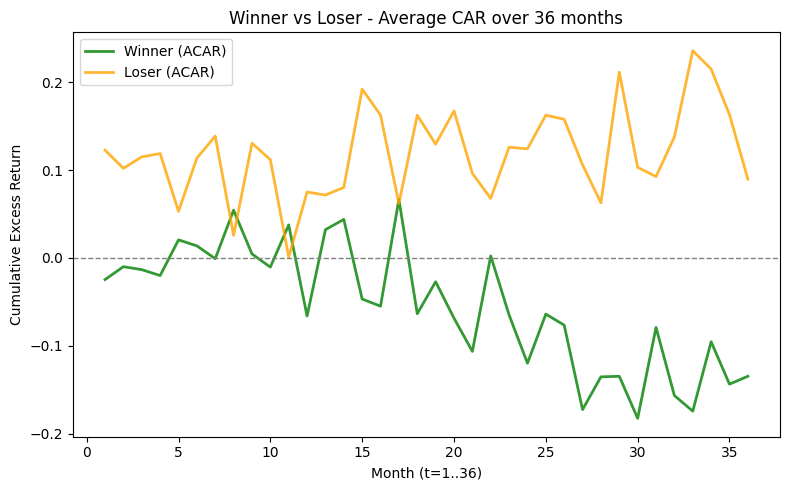

In [26]:
import matplotlib.pyplot as plt

# 假设之前计算好的acar已包含 t, ACAR_w, ACAR_l
# 这里只展示绘图部分

plt.figure(figsize=(8,5))

# Winner，示例用绿色，线稍粗、透明度适中
plt.plot(
    acar['t'], acar['ACAR_w'],
    label='Winner (ACAR)',
    color='green',
    linewidth=2,
    alpha=0.8
)

# Loser，示例用橙色，风格同上
plt.plot(
    acar['t'], acar['ACAR_l'],
    label='Loser (ACAR)',
    color='orange',
    linewidth=2,
    alpha=0.8
)

# 零参考线
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# 与原脚本含义一致的标签和标题
plt.xlabel('Month (t=1..36)')
plt.ylabel('Cumulative Excess Return')
plt.title('Winner vs Loser - Average CAR over 36 months')

plt.legend()
plt.tight_layout()
plt.show()


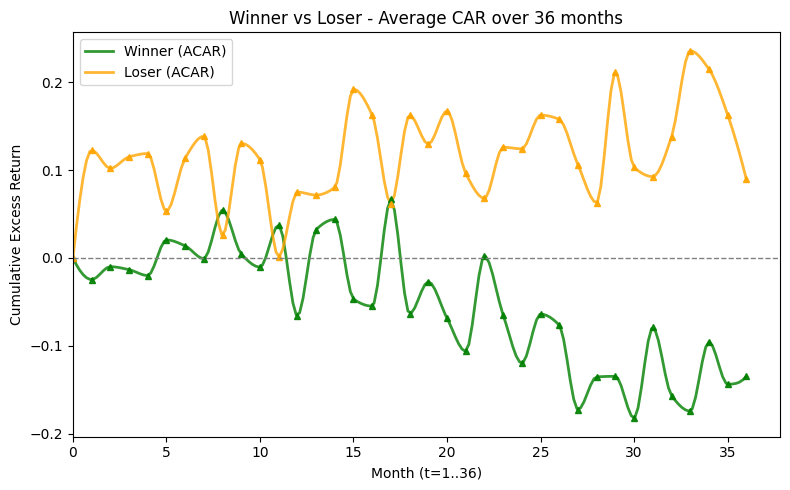

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# 假设 acar 里已有以下列:
#  - acar['t']: 1..36
#  - acar['ACAR_w']: Winner 的累计超额收益
#  - acar['ACAR_l']: Loser 的累计超额收益

#============ 1) 数据处理，让曲线从 (0,0) 出发 ============
t_vals = acar['t'].values            # [1, 2, 3, ..., 36]
w_vals = acar['ACAR_w'].values       # winner y值
l_vals = acar['ACAR_l'].values       # loser y值

# 在头部插入 (0,0)，让曲线从原点开始
t_w = np.insert(t_vals, 0, 0)
w_w = np.insert(w_vals, 0, 0)
t_l = np.insert(t_vals, 0, 0)
w_l = np.insert(l_vals, 0, 0)

#============ 2) 使用 PchipInterpolator 构造插值函数 ============
# 它会保证插值后的曲线恰好通过每个给定点
pchip_w = PchipInterpolator(t_w, w_w)
pchip_l = PchipInterpolator(t_l, w_l)

#============ 3) 生成较密集的 x 值以绘制平滑曲线 ============
# 这里以 0~36 为区间，200个点可视需要修改
x_smooth = np.linspace(0, 36, 200)

# 在这些 x_smooth 上分别计算 Winner/Loser 的插值
w_smooth = pchip_w(x_smooth)
l_smooth = pchip_l(x_smooth)

#============ 4) 开始绘图 ============
plt.figure(figsize=(8,5))

# (a) 平滑插值曲线
plt.plot(
    x_smooth, w_smooth,
    label='Winner (ACAR)',
    color='green',
    linewidth=2,
    alpha=0.8
)
plt.plot(
    x_smooth, l_smooth,
    label='Loser (ACAR)',
    color='orange',
    linewidth=2,
    alpha=0.8
)

# (b) 在每个整数 t 点上用三角标记，保证肉眼可见曲线“确实穿过这些点”
plt.plot(
    t_w, w_w,
    marker='^', markersize=5,
    linestyle='None',
    color='green',
    alpha=0.9
)
plt.plot(
    t_l, w_l,
    marker='^', markersize=5,
    linestyle='None',
    color='orange',
    alpha=0.9
)

# (c) 参考线、边界等
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlim(left=0)  # 让(0,0)紧贴纵轴
plt.xlabel('Month (t=1..36)')
plt.ylabel('Cumulative Excess Return')
plt.title('Winner vs Loser - Average CAR over 36 months')
plt.legend()
plt.tight_layout()
plt.show()


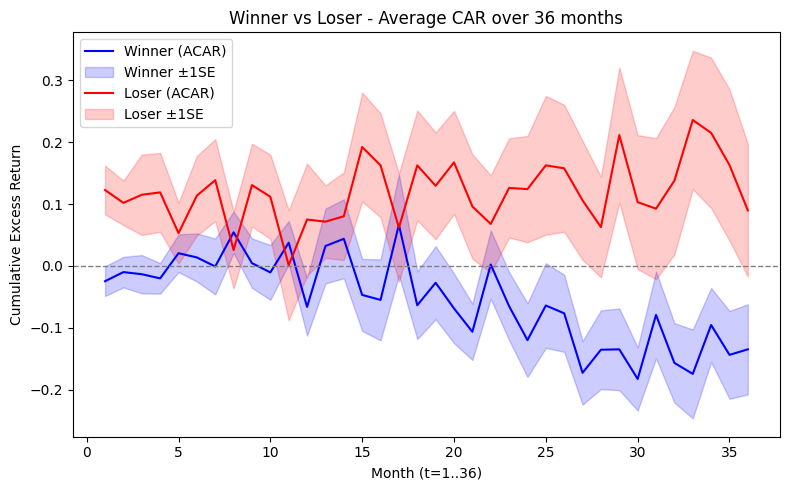

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------
# （1）先计算每个 t 对应的均值和标准误
# ------------------------------------------------
# grouped_n 里包含 (t, test_period_start, CAR_w, CAR_l)
# 每个 t 最多有 16 期，先聚合得到均值、标准差、样本量
stats_by_t = (
    grouped_n
    .groupby('t', as_index=False)
    .agg(
        w_mean=('CAR_w','mean'),
        w_std =('CAR_w','std'),
        w_count=('CAR_w','count'),
        l_mean=('CAR_l','mean'),
        l_std =('CAR_l','std'),
        l_count=('CAR_l','count')
    )
)

# 计算标准误(SE) = 标准差 / sqrt(样本数)
stats_by_t['w_se'] = stats_by_t['w_std'] / np.sqrt(stats_by_t['w_count'])
stats_by_t['l_se'] = stats_by_t['l_std'] / np.sqrt(stats_by_t['l_count'])

# 也可以改成 95% 置信区间 ≈ ±1.96 * SE，看需求：
# stats_by_t['w_se'] *= 1.96
# stats_by_t['l_se'] *= 1.96

# ------------------------------------------------
# （2）绘图：两条均值曲线，并在周围填充 ±SE
# ------------------------------------------------
plt.figure(figsize=(8,5))

# Winner
plt.plot(
    stats_by_t['t'], stats_by_t['w_mean'],
    color='blue', label='Winner (ACAR)'
)
plt.fill_between(
    stats_by_t['t'],
    stats_by_t['w_mean'] - stats_by_t['w_se'],
    stats_by_t['w_mean'] + stats_by_t['w_se'],
    color='blue', alpha=0.2,
    label='Winner ±1SE'
)

# Loser
plt.plot(
    stats_by_t['t'], stats_by_t['l_mean'],
    color='red', label='Loser (ACAR)'
)
plt.fill_between(
    stats_by_t['t'],
    stats_by_t['l_mean'] - stats_by_t['l_se'],
    stats_by_t['l_mean'] + stats_by_t['l_se'],
    color='red', alpha=0.2,
    label='Loser ±1SE'
)

# 参考线
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# 轴标签和标题，与原意义保持一致
plt.xlabel('Month (t=1..36)')
plt.ylabel('Cumulative Excess Return')
plt.title('Winner vs Loser - Average CAR over 36 months')

plt.legend()
plt.tight_layout()
plt.show()


In [24]:
'''
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ============ (1) 读取 & 预处理数据 ============ #
data_path = '../data/monthly/monthly.csv'
monthly_raw_data = pd.read_csv(data_path)

# 确保 RETX 列为数值类型，将无效值转换为 NaN
monthly_raw_data['RETX'] = pd.to_numeric(monthly_raw_data['RETX'], errors='coerce')

# 移除含有 NaN 的行
cleaned_data = monthly_raw_data.dropna(subset=['RETX'])

# 转换日期格式
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# 假设每支股票至少需要 85 个月数据
stocks_with_enough_data = cleaned_data.groupby('PERMNO').filter(lambda x: len(x) >= 85)

# 按日期排序，以防后面 rolling、cumsum 等操作时顺序混乱
stocks_with_enough_data = stocks_with_enough_data.sort_values(['PERMNO','date']).reset_index(drop=True)

print(f"符合条件的股票数量: {stocks_with_enough_data['PERMNO'].nunique()}")

# ============ (2) 拟先计算过去36个月的滚动累积超额收益 ============ #
#    （根据你的实际需求，这一步可以改成复合收益计算，比如 (1 + RETX).rolling.prod() - 1）
def calculate_cumulative_excess_returns(group):
    # group 已按日期排序
    group['cum_excess_return'] = group['RETX'].rolling(window=36, min_periods=36).sum()
    return group

stocks_with_enough_data = (
    stocks_with_enough_data
    .groupby('PERMNO', group_keys=False)
    .apply(calculate_cumulative_excess_returns)
)

# ============ (3) 取“实际有数据的所有日期”并升序去重 ============ #
all_dates = stocks_with_enough_data['date'].sort_values().unique()

# 这里假设，我们想做一个“每隔36个观测期”调一次仓的回测
# i 从 36 到 len(all_dates)-36，这样：
#   - 前 36 期可用来当 lookback
#   - 后 36 期可用来当持有期
step = 36
results = []

for i in range(36, len(all_dates) - 36, step):
    portfolio_date = all_dates[i]             # (A) 当前的portfolio_date
    next_portfolio_date = all_dates[i + step] # (B) 下一个portfolio_date
    
    # ============ (3.1) 确定 lookback 窗口（前36个月） ============ #
    # 只是一个示例：如果要严格最近 36 个月，可做：
    lookback_start = all_dates[i - 36]
    lookback_end = portfolio_date  # 包含该日
    
    lookback_data = stocks_with_enough_data[
        (stocks_with_enough_data['date'] >= lookback_start) &
        (stocks_with_enough_data['date'] <= lookback_end)
    ].copy()
    
    # 如果回溯期数据不足，就跳过
    if lookback_data.empty:
        continue
    
    # 在 lookback 窗口内，最后一条记录（往往就是 portfolio_date 或更早）会含有 cum_excess_return
    # 但并不一定“恰好 == portfolio_date”，因此：
    #   - 我们可以对每只股票取 <= portfolio_date 的最新一条。
    #   - 这样即可得到其在这36个月的累积表现。
    lookback_sub = lookback_data[lookback_data['date'] <= portfolio_date]
    portfolio_data = lookback_sub.groupby('PERMNO', group_keys=False).tail(1).copy()

    # ============ (3.2) 对组合数据做分组：赢家 vs. 输家 ============ #
    # 原先写法：
    # portfolio_data['rank'] = portfolio_data['cum_excess_return'].rank()
    # winner_portfolio = portfolio_data[
    #     portfolio_data['rank'] > portfolio_data['rank'].quantile(0.9)
    # ]
    # loser_portfolio = portfolio_data[
    #     portfolio_data['rank'] < portfolio_data['rank'].quantile(0.1)
    # ]

    # 新写法：改为取最高 35 只和最低 35 只
    portfolio_data = portfolio_data.sort_values('cum_excess_return', ascending=False)

    winner_portfolio = portfolio_data.head(35)  # 超额回报最高的 35 只
    loser_portfolio = portfolio_data.tail(35)   # 超额回报最低的 35 只

    
    # ============ (3.3) 确定测试期：(portfolio_date+1, next_portfolio_date-1] ============ #
    test_start_date = portfolio_date + pd.Timedelta(days=1)
    test_end_date = next_portfolio_date - pd.Timedelta(days=1)
    
    # 如果 test_start_date > test_end_date, 说明两个 portfolio_date 太近了，跳过
    if test_start_date > test_end_date:
        continue

    winner_test_data = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(winner_portfolio['PERMNO'])) &
        (stocks_with_enough_data['date'] >= test_start_date) &
        (stocks_with_enough_data['date'] <= test_end_date)
    ].copy()
    loser_test_data = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(loser_portfolio['PERMNO'])) &
        (stocks_with_enough_data['date'] >= test_start_date) &
        (stocks_with_enough_data['date'] <= test_end_date)
    ].copy()
    
    # 统计股票数量（去重）
    winner_n_stocks = winner_test_data['PERMNO'].nunique()
    loser_n_stocks = loser_test_data['PERMNO'].nunique()
    
    # 如果测试期里没有数据，也可能导致持股数为0
    if winner_test_data.empty or loser_test_data.empty:
        results.append({
            'portfolio_date': portfolio_date,
            'test_start_date': test_start_date,
            'test_end_date': test_end_date,
            'winner_n_stocks': winner_n_stocks,
            'loser_n_stocks': loser_n_stocks,
            'winner_avg_holding_return': np.nan,
            'loser_avg_holding_return': np.nan,
            't_stat': np.nan,
            'p_value': np.nan
        })
        continue

    # ============ (3.4) 计算在测试期内每只股票的累计回报(简单 cumsum 示例) ============ #
    winner_test_data = winner_test_data.sort_values(['PERMNO','date'])
    loser_test_data = loser_test_data.sort_values(['PERMNO','date'])

    winner_test_data['cumulative_return'] = (
        winner_test_data.groupby('PERMNO')['RETX'].cumsum()
    )
    loser_test_data['cumulative_return'] = (
        loser_test_data.groupby('PERMNO')['RETX'].cumsum()
    )

    # ============ (3.5) 计算每个月横截面平均 (给 T 检验用) ============ #
    winner_mean_car = winner_test_data.groupby('date')['cumulative_return'].mean()
    loser_mean_car = loser_test_data.groupby('date')['cumulative_return'].mean()
    t_stat, p_value = ttest_ind(winner_mean_car, loser_mean_car, nan_policy='omit')

    # ============ (3.6) 计算“测试期持有期平均收益” ============ #
    winner_holding_return = (
        winner_test_data.groupby('PERMNO')['cumulative_return'].last().mean()
    )
    loser_holding_return = (
        loser_test_data.groupby('PERMNO')['cumulative_return'].last().mean()
    )

    results.append({
        'portfolio_date': portfolio_date,
        'test_start_date': test_start_date,
        'test_end_date': test_end_date,
        'winner_n_stocks': winner_n_stocks,
        'loser_n_stocks': loser_n_stocks,
        'winner_avg_holding_return': winner_holding_return,
        'loser_avg_holding_return': loser_holding_return,
        't_stat': t_stat,
        'p_value': p_value
    })

# 转成 DataFrame 并查看
results_df = pd.DataFrame(results)
print(results_df)
'''


'\nimport pandas as pd\nfrom scipy.stats import ttest_ind\nimport numpy as np\nimport warnings\nwarnings.filterwarnings("ignore")\n\n# ============ (1) 读取 & 预处理数据 ============ #\ndata_path = \'../data/monthly/monthly.csv\'\nmonthly_raw_data = pd.read_csv(data_path)\n\n# 确保 RETX 列为数值类型，将无效值转换为 NaN\nmonthly_raw_data[\'RETX\'] = pd.to_numeric(monthly_raw_data[\'RETX\'], errors=\'coerce\')\n\n# 移除含有 NaN 的行\ncleaned_data = monthly_raw_data.dropna(subset=[\'RETX\'])\n\n# 转换日期格式\ncleaned_data[\'date\'] = pd.to_datetime(cleaned_data[\'date\'])\n\n# 假设每支股票至少需要 85 个月数据\nstocks_with_enough_data = cleaned_data.groupby(\'PERMNO\').filter(lambda x: len(x) >= 85)\n\n# 按日期排序，以防后面 rolling、cumsum 等操作时顺序混乱\nstocks_with_enough_data = stocks_with_enough_data.sort_values([\'PERMNO\',\'date\']).reset_index(drop=True)\n\nprint(f"符合条件的股票数量: {stocks_with_enough_data[\'PERMNO\'].nunique()}")\n\n# ============ (2) 拟先计算过去36个月的滚动累积超额收益 ============ #\n#    （根据你的实际需求，这一步可以改成复合收益计算，比如 (1 + RETX).rolling.prod() - 1）\n